In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

First general equation:

$$ P(C|R,S,W) = P(C|R,S) = \frac{P(C,S,R)}{P(S,R)} = \frac{P(C,S,R)}{\sum_{C}P(C,S,R)} = \frac{P(C)P(S|C)P(R|C)}{\sum_{C}P(C)P(S|C)P(R|C)} = \frac{P(C)P(S|C)P(R|C)}{C_1}$$

1) $$ \small P(C = T|R = T, S = T, W = T) = \frac{P(C = T)P(S = T|C = T)P(R = T|C = T)}{P(C = T)P(S = T|C = T)P(R = T|C = T) + P(C = F)P(S = T|C = F)P(R = T|C = F)} = \frac{0.5 * 0.1 * 0.8}{0.5 * 0.1 * 0.8 + 0.5 * 0.5 * 0.2} \approx 0.444 $$

2) $$ \small P(C = T|R = F, S = T, W = T) = \frac{P(C = T)P(S = T|C = T)P(R = F|C = T)}{P(C = T)P(S = T|C = T)P(R = F|C = T) + P(C = F)P(S = T|C = F)P(R = F|C = F)} = \frac{0.5 * 0.1 * 0.2}{0.5 * 0.1 * 0.2 + 0.5 * 0.5 * 0.8} \approx 0.048 $$

Second geneal equation:
$$ P(R|C,S,W) = \frac{P(R,C,S,W)}{P(C,S,W)} = \frac{P(R,C,S,W)}{\sum_{R}P(R,C,S,W)} = \frac{P(C)P(S|C)P(R|C)P(W|S,R)}{\sum_{R}P(C)P(S|C)P(R|C)P(W|S,R)} = \frac{P(C)P(S|C)P(R|C)P(W|S,R)}{C_2} $$

3) $$ \small P(R = T|C = T, S = T, W = T) = \frac{P(C = T)P(S = T|C = T)P(R = T|C = T)P(W = T|S = T,R = T)}{P(C = T)P(S = T|C = T)P(R = T|C = T)P(W = T|S = T,R = T) + P(C = T)P(S = T|C = T)P(R = F|C = T)P(W = T|S = T,R = F)} = \\ = \frac{0.8 * 0.99}{0.8 * 0.99 + 0.2 * 0.9} \approx 0.815 $$

4) $$ \small P(R = T|C = F, S = T, W = T) = \frac{P(C = F)P(S = T|C = F)P(R = T|C = F)P(W = T|S = T,R = T)}{P(C = F)P(S = T|C = F)P(R = T|C = F)P(W = T|S = T,R = T) + P(C = F)P(S = T|C = F)P(R = F|C = F)P(W = T|S = T,R = F)} = \\ = \frac{0.2 * 0.99}{0.2 * 0.99 + 0.8 * 0.9} \approx 0.216 $$


Implement the Gibbs sampler sketched above for the Bayesian network in Figure 1 and draw 100 samples from the joint probability distribution P(R, C | S = T, W = T) (4 point) 

In [13]:
class GibbsSampler:
    def __init__(self, C_prob: pd.DataFrame, R_prob: pd.DataFrame, S_prob: pd.DataFrame, W_prob: pd.DataFrame, e: dict):
        """
        Args:
            C_prob: conditional probability DataFrame for P(C)
            R_prob: conditional probability DataFrame for P(R|C)
            S_prob: conditional probability DataFrame for P(S|C)
            W_prob: conditional probabilityDataFrame for P(W|R, S)
            e: dictionary with evidence variables 
        """
        self.C_prob = C_prob
        self.R_prob = R_prob
        self.S_prob = S_prob
        self.W_prob = W_prob
        self.e = e
        self.samples_matrix = np.empty((0, 4))
    
    def calculate_C_prob(self, current_state: list, C_value: str):
        """
        Args:
            current_state: list of current state of the variables [C, R, S, W]
        Return: 
            probability of passed C value
        """
        nominator = self.C_prob.loc[0, C_value] * self.R_prob.loc[self.R_prob.loc[:, 'C'] == C_value, [current_state[1]]].iloc[0, 0] * self.S_prob.loc[self.S_prob.loc[:, 'C'] == C_value, [current_state[2]]].iloc[0, 0]
        denominator = (self.C_prob.loc[0, 'T'] * self.R_prob.loc[self.R_prob.loc[:, 'C'] == 'T', [current_state[1]]].iloc[0, 0] * self.S_prob.loc[self.S_prob.loc[:, 'C'] == 'T', [current_state[2]]].iloc[0, 0] + 
                        self.C_prob.loc[0, 'F'] * self.R_prob.loc[self.R_prob.loc[:, 'C'] == 'F', [current_state[1]]].iloc[0, 0] * self.S_prob.loc[self.S_prob.loc[:, 'C'] == 'F', [current_state[2]]].iloc[0, 0])
        return nominator/denominator
        
    def calculate_R_prob(self, current_state: list, R_value: str):
        """
        Args:
            current_state: list of current state of the variables [C, R, S, W]
        Return:
            probability of passed R value
        """
        nominator = float(self.R_prob.loc[self.R_prob.loc[:, 'C'] == current_state[0], R_value]) * float(self.W_prob.loc[(self.W_prob.loc[:, 'S'] == current_state[2]) & (self.W_prob.loc[:, 'R'] == R_value), current_state[3]])
        denominator = (float(self.R_prob.loc[self.R_prob.loc[:, 'C'] == current_state[0], 'T']) * float(self.W_prob.loc[(self.W_prob.loc[:, 'S'] == current_state[2]) & (self.W_prob.loc[:, 'R'] == 'T'), current_state[3]]) +
                        float(self.R_prob.loc[self.R_prob.loc[:, 'C'] == current_state[0], 'F']) * float(self.W_prob.loc[(self.W_prob.loc[:, 'S'] == current_state[2]) & (self.W_prob.loc[:, 'R'] == 'F'), current_state[3]]))
        return nominator/denominator

    def calculate_S_prob(self, current_state: list, S_value: str):
        """
        Args:
            current_state: list of current state of the variables [C, R, S, W]
        Return:
            probability of passed S value
        """
        nominator = float(self.S_prob.loc[self.S_prob.loc[:, 'C'] == current_state[0], S_value]) * float(self.W_prob.loc[(self.W_prob.loc[:, 'R'] == current_state[1]) & (self.W_prob.loc[:, 'S'] == S_value), current_state[3]])
        denominator = (float(self.S_prob.loc[self.S_prob.loc[:, 'C'] == current_state[0], 'T']) * float(self.W_prob.loc[(self.W_prob.loc[:, 'R'] == current_state[1]) & (self.W_prob.loc[:, 'S'] == 'T'), current_state[3]]) +
                        float(self.S_prob.loc[self.S_prob.loc[:, 'C'] == current_state[0], 'F']) * float(self.W_prob.loc[(self.W_prob.loc[:, 'R'] == current_state[1]) & (self.W_prob.loc[:, 'S'] == 'F'), current_state[3]]))
        return nominator/denominator
    
    def calculate_W_prob(self, current_state: list, W_value: str):
        """
        Args:
            current_state: list of current state of the variables [C, R, S, W]
        Return:
            sampled value of W
        """
        nominator = self.W_prob.loc[(self.W_prob.loc[:, 'R'] == current_state[1]) & (self.W_prob.loc[:, 'S'] == current_state[2]), W_value]
        denominator = (self.W_prob.loc[(self.W_prob.loc[:, 'R'] == current_state[1]) & (self.W_prob.loc[:, 'S'] == current_state[2]), 'T'] +
                        self.W_prob.loc[(self.W_prob.loc[:, 'R'] == current_state[1]) & (self.W_prob.loc[:, 'S'] == current_state[2]), 'F'])
        return nominator/denominator    
    
    def choose_value(self, current_state: list, calculate_prob):
        """
        Args:
            current_state: list of current state of the variables [C, R, S, W]
            calculate_prob: function to calculate probability of each value
        Return:
            sampled value
        """
        prob_true = calculate_prob(current_state, 'T')
        prob_false = calculate_prob(current_state, 'F')
        return np.random.choice(['T', 'F'], p=[prob_true, prob_false])
    
    def sample(self, n: int):
        """
        Args:
            n: number of samples to be generated
        """
        variales = ['C', 'R', 'S', 'W']
        x_variables = []
        init_step = []
        for var in variales:
            if var in self.e.keys():
                init_step.append(self.e[var])
            else:
                init_step.append(np.random.choice(['T', 'F']))
                x_variables.append(var)
        # add initial step to samples matrix
        self.samples_matrix = np.append(self.samples_matrix, np.array([init_step]), axis=0)
        # start sampling
        for i in tqdm(range(n)):
            xi = np.random.choice(x_variables)
            current_step = self.samples_matrix[i].copy()
            idx = variales.index(xi)
            if xi == 'C':
                current_step[idx] = self.choose_value(current_step, self.calculate_C_prob)
            elif xi == 'R':
                current_step[idx] = self.choose_value(current_step, self.calculate_R_prob)
            elif xi == 'S':
                current_step[idx] = self.choose_value(current_step, self.calculate_S_prob)
            elif xi == 'W':
                current_step[idx] = self.choose_value(current_step, self.calculate_W_prob)
            self.samples_matrix = np.append(self.samples_matrix, np.array([current_step]), axis=0)
            
        return pd.DataFrame(self.samples_matrix, columns=['C', 'R', 'S', 'W']).iloc[1:, :]           

In [4]:
C_prob = pd.DataFrame({'T': 0.5, 'F': 0.5}, index=[0])
R_prob = pd.DataFrame({'C': ['T', 'F'], 'T': [0.8, 0.2], 'F': [0.2, 0.8]})
S_prob = pd.DataFrame({'C': ['T', 'F'], 'T': [0.1, 0.5], 'F': [0.9, 0.5]})
W_prob = pd.DataFrame({'R': ['T', 'T', 'F', 'F'], 'S': ['T', 'F', 'T', 'F'], 'T': [0.99, 0.9, 0.9, 0.01], 'F': [0.01, 0.1, 0.1, 0.99]})
evidence = {'S': 'T', 'W': 'T'}

In [14]:
GB = GibbsSampler(C_prob, R_prob, S_prob, W_prob, evidence)
samples = GB.sample(100)
samples

100%|██████████| 100/100 [00:01<00:00, 68.62it/s]


,C,R,S,W
1,F,F,T,T
2,F,F,T,T
3,F,F,T,T
4,F,T,T,T
5,F,T,T,T
...,...,...,...,...
96,F,F,T,T
97,F,F,T,T
98,F,F,T,T
99,F,F,T,T


In [15]:
R_true_count = len(samples.loc[samples.loc[:, 'R'] == 'T', :])
prob = R_true_count/len(samples)
prob

0.29

# Convergence Diagnostics

In [9]:
samples_50000_1 = GB.sample(50000)
samples_50000_2 = GB.sample(50000)

100%|██████████| 50000/50000 [17:59<00:00, 46.33it/s]


In [11]:
R_true_count = len(samples_50000_1.loc[samples_50000_1.loc[:, 'R'] == 'T', :])
prob = R_true_count/len(samples_50000_1)
prob

0.32117123410710363

In [ ]:
# first run of the sampler
samples_50000_1['step'] = np.arange(0, len(samples_50000_1))
# for each step calculate frequency of R = T
samples_50000_1['R_freq'] = samples_50000_1.loc[:, 'R'].rolling(50000).sum()

In [19]:
# first run of the sampler
samples_50000_1['step'] = np.arange(1, len(samples_50000_1)+1)
# for each step calculate frequency of R = T
samples_50000_1['R_true_count'] = 0
samples_50000_1['C_true_count'] = 0
# for each row take the value of R_freq of previous row and add 1 if R = T
samples_50000_1['R_true_count'] = samples_50000_1['R'].apply(lambda x: 1 if x == 'T' else 0).cumsum()
samples_50000_1['C_true_count'] = samples_50000_1['C'].apply(lambda x: 1 if x == 'T' else 0).cumsum()

samples_50000_1['R_freq'] = samples_50000_1['R_true_count']/samples_50000_1['step']
samples_50000_1['C_freq'] = samples_50000_1['C_true_count']/samples_50000_1['step']

<AxesSubplot:xlabel='step'>

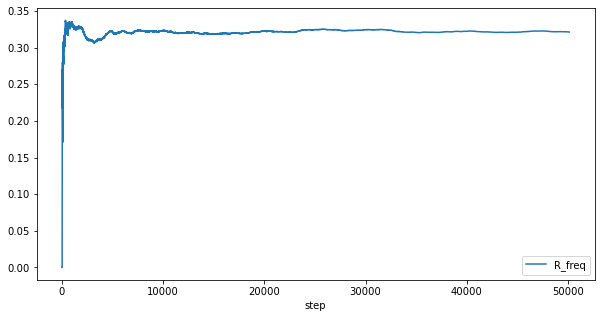

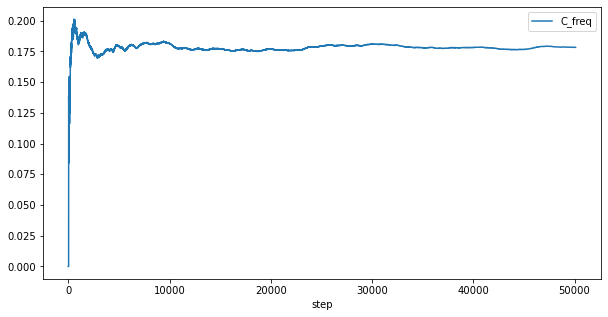

In [20]:
samples_50000_1.plot(x='step', y='R_freq', figsize=(10, 5))
samples_50000_1.plot(x='step', y='C_freq', figsize=(10, 5))

<AxesSubplot:title={'center':'Frequency of R = T'}, xlabel='step'>

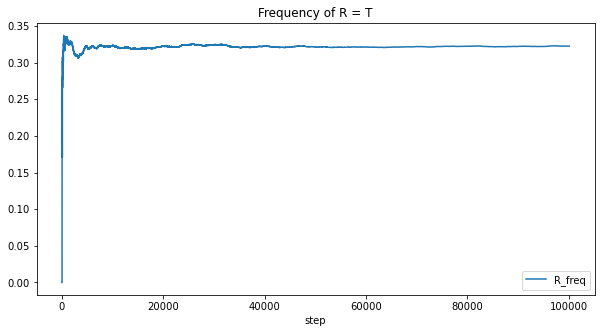

In [17]:
# first run of the sampler
samples_50000_2['step'] = np.arange(1, len(samples_50000_2)+1)
# for each step calculate frequency of R = T
samples_50000_2['R_true_count'] = 0
# for each row take the value of R_freq of previous row and add 1 if R = T
samples_50000_2['R_true_count'] = samples_50000_2['R'].apply(lambda x: 1 if x == 'T' else 0).cumsum()

samples_50000_2['R_freq'] = samples_50000_2['R_true_count']/samples_50000_2['step']
samples_50000_2.plot(x='step', y='R_freq', figsize=(10, 5), title='Frequency of R = T')